Using numpy backend.


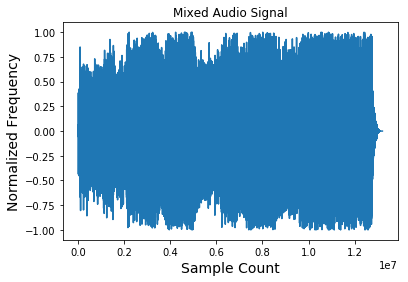

In [1]:
%matplotlib inline

import tensorly as tl
import numpy as np
from scipy.misc import face, imresize
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil

import madmom
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import librosa
import librosa.display

from scipy.ndimage.filters import maximum_filter

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

#signal, sample_rate = madmom.io.audio.load_wave_file('data/sample1/sample3.wav')
signal, sample_rate = librosa.load('data/sample1/song.wav', sr=44100)

plt.figure()
plt.xlabel("Sample Count", fontsize=14, rotation=0)
plt.ylabel("Normalized Frequency", fontsize=14, rotation=90)
plt.title('Mixed Audio Signal')
plt.plot(signal)

plt.savefig("mixedsignal.png", dpi=150)

In [2]:
spec, phase = librosa.magphase(librosa.stft(signal))

print(spec.shape)


(1025, 25786)


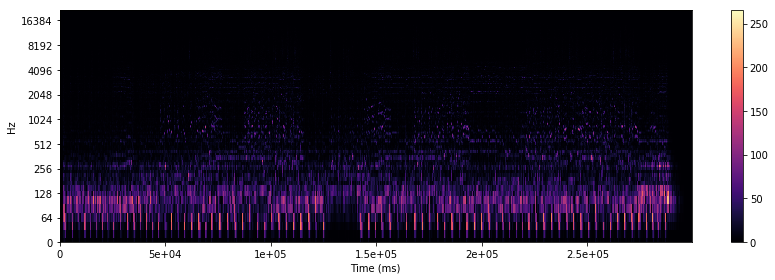

In [4]:

plt.figure(figsize=(12, 4))
#Convert an amplitude spectrogram to dB-scaled spectrogram.
librosa.display.specshow(spec, y_axis='log', x_axis='ms', sr=sample_rate)

plt.colorbar()
plt.tight_layout()

plt.savefig("spectrogram.png", dpi=150)

In [7]:
numrows = len(spec)
numcols = len(spec[0])
print(numcols)
I = numrows
J = 30
K = math.floor(numcols/30)

print(spec.shape)
print(I,J,K)

25786
(1025, 25786)
1025 30 859


In [8]:
X =  np.zeros((I,J,K))

for k in range (K):
    for i in range (I):
        for j in range (J):
            X[i,j,k] = spec[i,j+k*J]

In [ ]:
from mpl_toolkits import mplot3d

z,x,y = X.nonzero()
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);

In [11]:
X_ten = tl.tensor(X, dtype='float64')

# Rank of the Tucker decomposition r1,r2,r3
r1=2 
r2=2
r3=2
tucker_rank = [r1, r2, r3]

# Tucker decomposition
core, tucker_factors = tucker(X_ten, ranks=tucker_rank, init='random', tol=10e-5, random_state=123)


In [12]:
import tensorflow as tf

list_of_specs = []

for i in range(0,r1):
    sliceW = tucker_factors[0][:,i]
    
    new_core = core[i,:,:]
    
    new_core = tf.reshape(new_core, [1, new_core.shape[0], new_core.shape[1]])
    new_core = tf.Session().run(new_core)
    
    new_tucker_factors = [sliceW, tucker_factors[1], tucker_factors[2]]
    new_tucker_factors[0] = tf.reshape(new_tucker_factors[0], [new_tucker_factors[0].shape[0], 1])
    new_tucker_factors[0] = tf.Session().run(new_tucker_factors[0])
    
    tucker_reconstruction = tl.tucker_to_tensor(new_core, new_tucker_factors)
    
    spec_reconstruction = np.zeros((numrows, numcols))
    for k in range (K):
        for i in range (I):
            for j in range (J):
                spec_reconstruction[i,j+k*J] = tucker_reconstruction[i,j,k]
    
    list_of_specs.append(spec_reconstruction)

list_of_specs = np.array(list_of_specs)

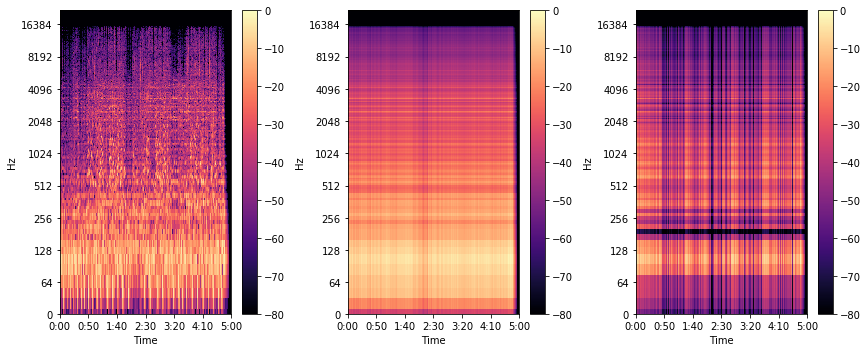

In [13]:
rp = np.max(np.abs(spec))

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)

plt.subplot(151)

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sample_rate)
plt.colorbar()
plt.tight_layout()


for i in range(r1):
    plt.subplot(152+i)
    
    librosa.display.specshow(librosa.amplitude_to_db(list_of_specs[i], ref=np.max), y_axis='log', x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.tight_layout()

plt.show()


In [ ]:
#masked = librosa.util.softmask(spec, list_of_specs[i], power=2)
new_signal= librosa.istft(spec)

filename = 'output/test'+ str(i) +'.wav'
librosa.output.write_wav(filename, list_of_specs[0], sample_rate)

In [ ]:
for i in range(0,r1):
    
    #list_of_specs[i] = [(j > 0) * j for j in list_of_specs[i]]
    
    S_filter = librosa.decompose.nn_filter(list_of_specs[i],
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sample_rate)))
    S_filter = np.minimum(list_of_specs[i], S_filter)
    
    margin_i, margin_v = 2, 10
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                   margin_i * (list_of_specs[i] - S_filter),
                                   power=power)

    mask_v = librosa.util.softmask(list_of_specs[i] - S_filter,
                                   margin_v * S_filter,
                                   power=power)
    
    S_foreground = mask_v * list_of_specs[i]
    
    #masked = librosa.util.softmask(spec, list_of_specs[i], power=2)
    new_signal= librosa.istft(S_foreground)
    
    
    filename = 'output/new'+ str(i) +'.wav'
    librosa.output.write_wav(filename, new_signal, sample_rate)
    